# Libs, data importing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modelling and Forecasting
# ==============================================================================
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from rich.progress import track
from datetime import date
from joblib import dump, load

# Configuration
# ==============================================================================
import warnings
import holidays
warnings.filterwarnings('ignore')



/home/jerzy/.conda/envs/indml/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data_train = pd.read_csv('/home/jerzy/Documents/IndustrialML/data/train_preprocessed.csv')
data_train.drop('Unnamed: 0', axis=1, inplace=True)


In [3]:
data_test = pd.read_csv('/home/jerzy/Documents/IndustrialML/data/test.csv')

In [4]:
data_val = pd.read_csv('/home/jerzy/Documents/IndustrialML/data/valid.csv')
# drop row 0101000020E610000000000000000000000000000000000000
data_val = data_val[data_val['point'] != '0101000020E610000000000000000000000000000000000000']

In [5]:
data_unique_points = data_train['point'].unique()
test_unique_points = data_test['point'].unique()
valid_unique_points = data_val['point'].unique()

# Split data into year, month, day, hour and adding holidays, weekends, weekdays

Add datetime column to test and valid datasets

In [6]:
data_test['datetime'] = pd.to_datetime(data_test['hour'], unit='s')
data_val['datetime'] = pd.to_datetime(data_val['hour'], unit='s')
data_train['datetime'] = pd.to_datetime(data_train['time'])

In [7]:
data_train

,point,lon,lat,time,timestamp,num_posts,datetime
0,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-22 11:00:00,1574420400,1,2019-11-22 11:00:00
1,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-22 12:00:00,1574424000,1,2019-11-22 12:00:00
2,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-23 13:00:00,1574514000,1,2019-11-23 13:00:00
3,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-25 16:00:00,1574697600,1,2019-11-25 16:00:00
4,0101000020E610000002A5EC7AB31D3E4097654065F8EA...,30.116020,59.835705,2019-11-27 10:00:00,1574848800,1,2019-11-27 10:00:00
...,...,...,...,...,...,...,...
3625651,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,30.522508,59.898840,2019-12-06 04:00:00,3151209600,2,2019-12-06 04:00:00
3625652,0101000020E6100000FF9D4C0EC3853E4094782B2D0DF3...,30.522508,59.898840,2019-12-23 08:00:00,1577088000,1,2019-12-23 08:00:00
3625653,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,30.522508,59.870670,2019-06-10 09:00:00,1560157200,1,2019-06-10 09:00:00
3625654,0101000020E6100000FF9D4C0EC3853E40ABD94A1972EF...,30.522508,59.870670,2019-10-06 14:00:00,1570370400,1,2019-10-06 14:00:00


Add yyyy, mm, dd, hh to test and valid

In [8]:
data_train["dayhour"] = data_train["datetime"].dt.hour
data_train["weekday"] = data_train["datetime"].dt.weekday

data_test["dayhour"] = data_test["datetime"].dt.hour
data_test["weekday"] = data_test["datetime"].dt.weekday

data_val["dayhour"] = data_val["datetime"].dt.hour
data_val["weekday"] = data_val["datetime"].dt.weekday

Add holidays

In [9]:
holidays_russia = holidays.country_holidays('RU', years = [2019, 2020])

data_train['is_holiday'] = data_train['datetime'].apply(lambda x: 1 if x in holidays_russia else 0)
data_test['is_holiday'] = data_test['datetime'].apply(lambda x: 1 if x in holidays_russia else 0)
data_val['is_holiday'] = data_val['datetime'].apply(lambda x: 1 if x in holidays_russia else 0)

In [10]:
data_train = data_train.drop(['time'], axis=1)

# Regressions: catboost, lightgbm and xgboost

In [11]:
# fig, ax = plt.subplots(figsize=(11, 4))

# data_train[data_train['point'] == '0101000020E6100000DBC1F19351543E4006FC5DE561F84D40']['num_posts'].plot(ax=ax, label='train')
# data_val[data_val['point'] == '0101000020E6100000DBC1F19351543E4006FC5DE561F84D40']['sum'].plot(ax=ax, label='validation')
# data_test[data_test['point'] == '0101000020E6100000DBC1F19351543E4006FC5DE561F84D40']['sum'].plot(ax=ax, label='test')
# ax.set_title('Number of users')
# ax.legend();

In [12]:
def custom_metric(y_true, y_pred):
    return abs(y_true - y_pred) / y_pred

def flatten(l):
    return [item for sublist in l for item in sublist]

def learn_regressor(data_train: pd.DataFrame, data_test: pd.DataFrame, model):

    data_test_boost_prediction = []
    data_test_boost_error = []
    test_unique_points = data_test['point'].unique()

    for point in track(test_unique_points, description='Learning'):
        model = model
        data_train_point = data_train[data_train['point'] == point]
        data_test_point = data_test[data_test['point'] == point]

        X_train = data_train_point[['timestamp', 'dayhour', 'weekday', 'is_holiday']]
        y_train = data_train_point['num_posts']

        X_test = data_test_point[['hour', 'dayhour', 'weekday', 'is_holiday']]
        X_test = X_test.rename(columns={'hour': 'timestamp'})
        y_test = data_test_point['sum']

        model.fit(X_train, y_train)
        y_pred = np.round(model.predict(X_test))
        data_test_boost_prediction.append(y_pred)
        data_test_boost_error.append(custom_metric(np.array(y_test), np.array(y_pred)))

    return data_test_boost_error, data_test_boost_prediction


## Mutual info score calculation

In [13]:
from sklearn.metrics import mutual_info_score

def mutual_info_matrix(data):
    mi_matrix = pd.DataFrame(index=data.columns, columns=data.columns)
    for i in track(data.columns, description='Calculating MI matrix'):
        for j in data.columns:
            mi_matrix.loc[i, j] = round(float(mutual_info_score(data[i], data[j])), 2)
    return mi_matrix

mi_train = mutual_info_matrix(data_train)

# convert all columns to float 
mi_train = mi_train.astype(float)

Output()

<AxesSubplot:>

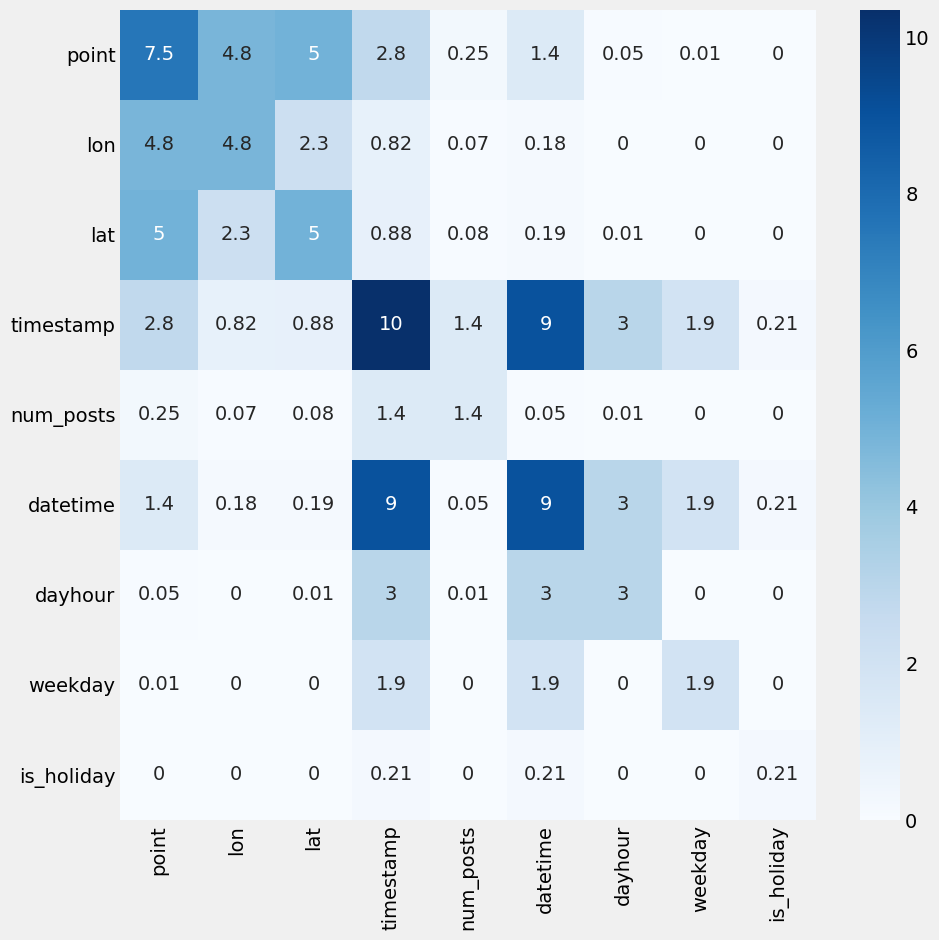

In [14]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(mi_train, annot=True, cmap='Blues')

<AxesSubplot:>

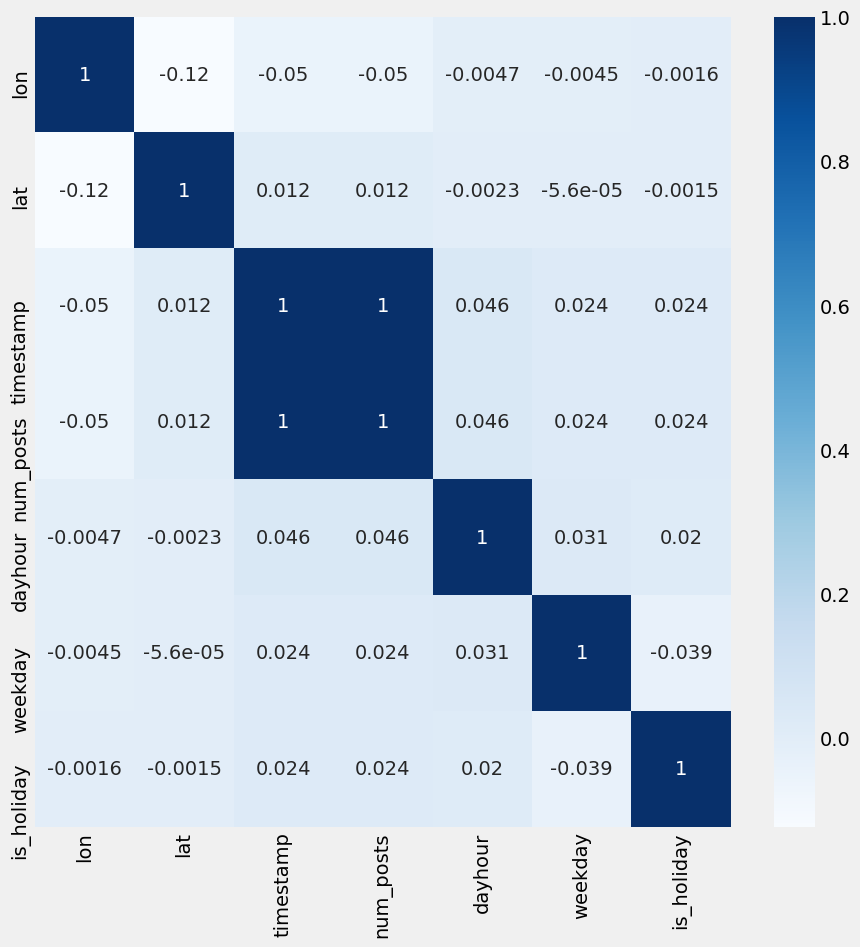

In [15]:
# correlation heatmap
# =================================================================================\
corr = data_train.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corr, annot=True, fmt='.2g',cmap='Blues')

## XGBoost

### test data

time = 36.2 s

error = 8.6828

In [16]:
%%time
data_test_xgboost_error, data_test_xgboost_predictions = learn_regressor(data_train, data_test, XGBRegressor())
data_test_xgboost_error = flatten(data_test_xgboost_error)
data_test_xgboost_predictions = flatten(data_test_xgboost_predictions)
data_test['xgboost_predictions'] = data_test_xgboost_predictions
data_test['xgboost_error'] = data_test_xgboost_error
data_test['xgboost_error'].mean()

Output()

CPU times: user 6min 52s, sys: 825 ms, total: 6min 52s
Wall time: 44.1 s


8.682857142857143

In [17]:
data_test

,hour,lat,lon,point,sum,error,datetime,dayhour,weekday,is_holiday,xgboost_predictions,xgboost_error
0,1582711200,59.934863,30.331616,0101000020E61000009BAC04C2E4543E40DB251193A9F7...,7,0.370265,2020-02-26 10:00:00,10,2,0,1.0,6.0
1,1581937200,59.940488,30.329370,0101000020E6100000DBC1F19351543E4006FC5DE561F8...,6,0.754735,2020-02-17 11:00:00,11,0,0,1.0,5.0
2,1581523200,59.905597,30.297929,0101000020E61000006AEBE80E454C3E407F614299EAF3...,5,3.754735,2020-02-12 16:00:00,16,2,0,1.0,4.0
3,1581512400,59.921359,30.356319,0101000020E6100000CFC2D4BC375B3E401FBF4913EFF5...,16,4.088069,2020-02-12 13:00:00,13,2,0,1.0,4.0
4,1581771600,59.939363,30.315895,0101000020E61000006141807FDE503E40A554BF083DF8...,10,2.088069,2020-02-15 13:00:00,13,5,0,1.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
695,1582059600,59.926986,30.331616,0101000020E61000009BAC04C2E4543E4070B5CC78A7F6...,6,0.754735,2020-02-18 21:00:00,21,1,0,1.0,4.0
696,1582038000,59.925860,30.295683,0101000020E6100000AB00D6E0B14B3E406379569882F6...,15,1.215399,2020-02-18 15:00:00,15,1,0,1.0,5.0
697,1581926400,59.937113,30.282208,0101000020E6100000328064CC3E483E400C288C4EF3F7...,20,18.754735,2020-02-17 08:00:00,8,0,0,1.0,6.0
698,1582099200,59.933737,30.322632,0101000020E61000009E01B90998523E407AB3D8B484F7...,8,2.754735,2020-02-19 08:00:00,8,2,0,1.0,4.0


### validation data

time = 37.2 s

error = 8.84839

In [18]:
%%time
data_val_xgboost_error, data_val_xgboost_predictions = learn_regressor(data_train, data_val, XGBRegressor())
data_val_xgboost_error = flatten(data_val_xgboost_error)
data_val_xgboost_predictions = flatten(data_val_xgboost_predictions)
data_val['xgboost_predictions'] = data_val_xgboost_predictions
data_val['xgboost_error'] = data_val_xgboost_error
data_val['xgboost_error'].mean()

Output()

CPU times: user 4min 14s, sys: 469 ms, total: 4min 14s
Wall time: 33.4 s


8.848396501457726

## CatBoost 

In [19]:
# 

### test data

time = 121.6 s

error = 1min 53s

In [20]:
%%time
data_test_catboost_error, data_test_catboost_predictions = learn_regressor(data_train, data_test, CatBoostRegressor(silent=True))
data_test_catboost_error = flatten(data_test_catboost_error)
data_test_catboost_predictions = flatten(data_test_catboost_predictions)
data_test['catboost_predictions'] = data_test_catboost_predictions
data_test['catboost_error'] = data_test_catboost_error
data_test['catboost_error'].mean()


Output()

CPU times: user 15min 3s, sys: 2min 35s, total: 17min 38s
Wall time: 1min 53s


7.697857142857143

### validation data

time = 124.9 s

error = 7.8411

In [21]:
%%time
data_val_catboost_error, data_val_catboost_predictions = learn_regressor(data_train, data_val, CatBoostRegressor(silent=True))
data_val_catboost_error = flatten(data_val_catboost_error)
data_val_catboost_predictions = flatten(data_val_catboost_predictions)
data_val['catboost_predictions'] = data_val_catboost_predictions
data_val['catboost_error'] = data_val_catboost_error
data_val['catboost_error'].mean()


Output()

CPU times: user 15min 27s, sys: 2min 40s, total: 18min 7s
Wall time: 1min 56s


7.841107871720117

## LightGBM

### test data

time = 27 s

error = 7.01214

In [22]:
%%time
data_test_lgdmboost_error, data_test_lgdmboost_predictions = learn_regressor(data_train, data_test, LGBMRegressor())
data_test_lgdmboost_error = flatten(data_test_lgdmboost_error)
data_test_lgdmboost_predictions = flatten(data_test_lgdmboost_predictions)
data_test['lgdmboost_predictions'] = data_test_lgdmboost_predictions
data_test['lgdmboost_error'] = data_test_lgdmboost_error
data_test['lgdmboost_error'].mean()


Output()

CPU times: user 2min 31s, sys: 555 ms, total: 2min 32s
Wall time: 25.9 s


7.012142857142857

### validation data

time = 28 s

error = 7.3272

In [23]:
%%time
data_val_lgdmboost_error, data_val_lgdmboost_predictions = learn_regressor(data_train, data_val, LGBMRegressor())
data_val_lgdmboost_error = flatten(data_val_lgdmboost_error)
data_val_lgdmboost_predictions = flatten(data_val_lgdmboost_predictions)
data_val['lgdmboost_predictions'] = data_val_lgdmboost_predictions
data_val['lgdmboost_error'] = data_val_lgdmboost_error
data_val['lgdmboost_error'].mean()

Output()

CPU times: user 2min 41s, sys: 609 ms, total: 2min 41s
Wall time: 27.2 s


7.327259475218659

In [24]:
data_test.to_csv('data/test_regressors_predictions.csv')
data_val.to_csv('data/val_regressors_predictions.csv')

In [25]:
data_test.describe()

,hour,lat,lon,sum,error,dayhour,weekday,is_holiday,xgboost_predictions,xgboost_error,catboost_predictions,catboost_error,lgdmboost_predictions,lgdmboost_error
count,7.000000e+02,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000,700.0,700.000000,700.000000,700.000000,700.000000,700.000000
mean,1.581748e+09,59.931030,30.331786,9.682857,2.620662,13.621429,3.100000,0.044286,1.0,8.682857,1.187143,7.697857,1.348571,7.012143
std,7.180874e+05,0.040814,0.073457,6.430390,4.055027,4.391545,2.043518,0.205876,0.0,6.430390,0.390305,6.153537,0.476859,6.218787
min,1.580537e+09,59.831191,30.142969,5.000000,0.004735,2.000000,0.000000,0.000000,1.0,4.000000,1.000000,1.500000,1.000000,1.500000
25%,1.581156e+09,59.921359,30.295683,5.000000,0.421402,10.000000,1.000000,0.000000,1.0,4.000000,1.000000,4.000000,1.000000,4.000000
50%,1.581741e+09,59.932612,30.322632,7.000000,1.269158,14.000000,3.000000,0.000000,1.0,6.000000,1.000000,5.500000,1.000000,5.000000
75%,1.582391e+09,59.940769,30.358565,11.000000,3.754735,17.000000,5.000000,0.000000,1.0,10.000000,1.000000,9.000000,2.000000,8.000000
max,1.583010e+09,60.039332,30.515770,40.000000,38.754735,23.000000,6.000000,1.000000,1.0,39.000000,2.000000,39.000000,2.000000,39.000000


In [26]:
data_val.describe()

,hour,lat,lon,sum,error,dayhour,weekday,is_holiday,xgboost_predictions,xgboost_error,catboost_predictions,catboost_error,lgdmboost_predictions,lgdmboost_error
count,6.860000e+02,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000,686.0,686.000000,686.000000,686.000000,686.000000,686.000000
mean,1.581783e+09,59.933357,30.327609,9.848397,2.644801,13.944606,3.123907,0.043732,1.0,8.848397,1.169096,7.841108,1.319242,7.327259
std,7.202487e+05,0.041569,0.068056,6.471299,3.868670,4.419911,2.061984,0.204647,0.0,6.471299,0.375110,5.964638,0.466523,6.491519
min,1.580548e+09,59.828934,30.142969,5.000000,0.003861,1.000000,0.000000,0.000000,1.0,4.000000,1.000000,1.500000,1.000000,1.500000
25%,1.581175e+09,59.921359,30.297929,6.000000,0.467870,10.000000,1.000000,0.000000,1.0,5.000000,1.000000,4.000000,1.000000,4.000000
50%,1.581799e+09,59.932612,30.322632,7.000000,1.408210,14.000000,3.000000,0.000000,1.0,6.000000,1.000000,6.000000,1.000000,5.000000
75%,1.582408e+09,59.949486,30.356319,11.000000,3.754735,18.000000,5.000000,0.000000,1.0,10.000000,1.000000,9.000000,2.000000,8.000000
max,1.583014e+09,60.039332,30.535982,40.000000,38.754735,23.000000,6.000000,1.000000,1.0,39.000000,2.000000,38.000000,2.000000,39.000000


In [28]:
data_train.describe()

,lon,lat,timestamp,num_posts,dayhour,weekday,is_holiday
count,3.625656e+06,3.625656e+06,3.625656e+06,3.625656e+06,3.625656e+06,3.625656e+06,3.625656e+06
mean,3.032788e+01,5.993524e+01,3.646984e+09,2.330739e+00,1.313461e+01,3.004492e+00,5.350618e-02
std,7.917094e-02,5.082867e-02,6.518689e+09,4.159461e+00,5.307628e+00,1.999440e+00,2.250406e-01
min,3.008907e+01,5.971474e+01,1.546301e+09,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.028445e+01,5.990898e+01,1.561568e+09,1.000000e+00,9.000000e+00,1.000000e+00,0.000000e+00
50%,3.032263e+01,5.993599e+01,1.574410e+09,1.000000e+00,1.300000e+01,3.000000e+00,0.000000e+00
75%,3.036755e+01,5.996747e+01,3.147343e+09,2.000000e+00,1.700000e+01,5.000000e+00,0.000000e+00
max,3.107722e+01,6.017923e+01,9.443520e+11,6.000000e+02,2.300000e+01,6.000000e+00,1.000000e+00
